In [1]:
import pycircos
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
import dalmatian as dm
# from plotting_methods import get_kataegis_clusters, kataegis_mut
from intervaltree import IntervalTree, Interval
import pdb
import math
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

# define chromosome size dictionary
csize = {'1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276, '5': 180915260, '6': 171115067, '7': 159138663,
         '8': 146364022,
         '9': 141213431, '10': 135534747, '11': 135006516, '12': 133851895, '13': 115169878, '14': 107349540,
         '15': 102531392,
         '16': 90354753, '17': 81195210, '18': 78077248, '19': 59128983, '20': 63025520, '21': 48129895, '22': 51304566,
         'X': 156040895}  #, 'Y': 57227415}

# define patients with FFPE preservation
# ffpe_names = ['RIC-001-UCSD-RS-01', 'RIC-009-MAYO-RS-01', 'DFCI-5450-RT-01',
#              'RIC-007-MAYO-RS-01', 'RIC-008-MAYO-RS-01', 'RIC-016-MAYO-RS-01']

# define maf columns needed
cols = ['Hugo_Symbol', 'Chromosome', 'Start_position', 'End_position', 'Reference_Allele', 'Tumor_Seq_Allele2', 't_alt_count', 't_ref_count']

# Helper functions

In [3]:
def prepare_df(df, csize, df_type='maf'):
    chr_order = np.asarray(list(csize.keys()))
    chrom_start = {chrom: start for (chrom, start) in
                   zip(np.append(chr_order, 'Z'), [0] + np.insert(np.cumsum([csize[a] for a in chr_order]), 0, 0))}

    df['Chromosome'] = df['Chromosome'].astype(str)
    df = df[df['Chromosome'].isin(chr_order)]

    if df_type == 'maf':
        suffix = '_position'
    else:
        suffix = '.bp'

    df['genome_start'] = df.apply(lambda x: chrom_start[str(x['Chromosome'])] + x[f'Start{suffix}'], axis=1)
    df['genome_end'] = df.apply(lambda x: chrom_start[str(x['Chromosome'])] + x[f'End{suffix}'], axis=1)

    return df, chr_order, chrom_start


def calc_intermutational_distance(maf, log=False):
    distance_prev = [np.nan] * maf.shape[0]
    for i in np.arange(1, maf.shape[0]):
        if log == True:
            distance_prev[i] = math.log(max(maf.iloc[i]['genome_start'] - maf.iloc[i-1]['genome_end'], 1), 10)
        else:
            distance_prev[i] = max(maf.iloc[i]['genome_start'] - maf.iloc[i-1]['genome_end'], 1)
    return distance_prev



def get_kataegis_clusters(maf, csize, sample_name, cutoff_val=None):
    maf, chr_order, chrom_start = prepare_df(maf, csize)

    maf['distance_prev'] = calc_intermutational_distance(maf)
    if cutoff_val is None:
        cutoff_val = calculate_cutoff(maf['distance_prev'])

    below_cutoff = maf['distance_prev'] < cutoff_val
    kataegis_cluster = []
    counter = 0
    for i, cutoff_bool in enumerate(below_cutoff):
        if cutoff_bool:
            counter += 1
        else:
            if counter >= 6:
                kataegis_cluster.append((i - counter, i - 1))
            counter = 0

    clusters_str = []
    clusters_df = []
    for (start, end) in kataegis_cluster:
        clusters_str.append(f"chr{maf.iloc[start]['Chromosome']}:{maf.iloc[start]['Start_position']}-"
                        f"chr{maf.iloc[end]['Chromosome']}:{maf.iloc[end]['Start_position']}")
        clusters_df.append([maf.iloc[start]['Chromosome'],
                            maf.iloc[start]['Start_position'],
                            maf.iloc[end]['Start_position']])
    clusters_df = pd.DataFrame(clusters_df, columns=['chr', 'start', 'end'])
    print(f'{sample_name} cutoff: {cutoff_val}, with {len(clusters_str)} clusters')
    return clusters_str, cutoff_val, clusters_df


def kataegis_mut(i_tree, mut_start, mut_chr):
    matching_intervals = i_tree[mut_start]
    if len(matching_intervals) == 0:
        return False
    else:
        chromosomes = [i.data for i in matching_intervals]
        return (np.asarray(chromosomes) == mut_chr).any()

In [17]:
# plot Garcs around the perimeter of the plot
def plot_circle(circle):
    
    chr_data = pd.read_csv('./chromosome_data.tsv', sep='\t')
    
    tmp = 0
    for _, chr in chr_data.iterrows():
        if tmp == 0:
            color = 'gainsboro'
            tmp = 1
        else:
            color = 'white'
            tmp = 0
        
        arc = Garc(arc_id=chr.chr, size=chr.end, interspace=3, raxis_range=(950,1000), facecolor=color, labelposition=60, label_visible=True)
        circle.add_garc(arc)
        
    circle.set_garcs()

# show cytobands on chromosomes
def plot_cytobands(circle):
    
    color_dict  = {"gneg":"#FFFFFF00", "gpos25":"#EEEEEE", "gpos50":"#BBBBBB", "gpos75":"#777777", "gpos100":"#000000", "gvar":"#FFFFFF00", "stalk":"#C01E27", 
                   "acen":"#D82322"}

    arcdata_dict = collections.defaultdict(dict)
    cyto_data = pd.read_csv('./cytoband_data.tsv', sep='\t')

    for _, band in cyto_data.iterrows():
        name  = band.chr
        width = int(band.end)-(int(band.start)-1)

        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["widths"]    = [] 
            arcdata_dict[name]["colors"]    = [] 

        arcdata_dict[name]["positions"].append(band.start) 
        arcdata_dict[name]["widths"].append(width)
        arcdata_dict[name]["colors"].append(color_dict[band.value2])

    for key in arcdata_dict:
        circle.barplot(key, data=[1]*len(arcdata_dict[key]["positions"]), positions=arcdata_dict[key]["positions"], 
                       width=arcdata_dict[key]["widths"], raxis_range=[950,1000], facecolor=arcdata_dict[key]["colors"]) 

def plot_linkplot(circle, sv_pt, radius=950):
    
    color_dict = {"deletion":"#EC2D06", "long_range":"#06ECBB", "inter_chr":"#0664EC", "tandem_dup":"#58A446", "inversion":"#CECB1E"}
    
    for _, sv in sv_pt.iterrows():
        name1  = 'chr' + str(sv.chr1) 
        start1 = sv.pos1
        end1   = start1 + 1
        name2  = 'chr' + str(sv.chr2)   
        start2 = sv.pos2
        end2   = start2 + 1
        source = (name1, start1, end1, radius)
        destination = (name2, start2, end2, radius)

        circle.chord_plot(source, destination, edgecolor= color_dict[sv['class']], linewidth=2)
        
def plot_absolutes(circle, seg_df, raxis_range, rlim=(0,2)):
    
    for _, seg in seg_df.iterrows():
        
        garc_id = 'chr' + str(seg.Chromosome)
        data1 = 2 * [seg['hscr.a1']]
        data2 = 2 * [seg['hscr.a2']]
        positions = [seg['Start.bp'], seg['End.bp']]
        
        circle.lineplot(garc_id=garc_id, data=data1, positions=positions, 
                        raxis_range=raxis_range, rlim=rlim, linecolor='black')
        
        circle.lineplot(garc_id=garc_id, data=data2, positions=positions, 
                        raxis_range=raxis_range, rlim=rlim, linecolor='black')
        

def plot_seg(circle, seg_df, raxis_range, rlim=(0,2)):
    
    seg_df.dropna(subset=['mu.minor', 'mu.major'], inplace=True)
    
    for _, seg in seg_df.iterrows():
        
        garc_id = 'chr' + str(int(seg.Chromosome))
        data1 = 2*[seg['mu.minor']]
        data2 = 2*[seg['mu.major']]
        positions = [seg['Start.bp'], seg['End.bp']]
        
        circle.lineplot(garc_id=garc_id, data=data1, positions=positions, 
                        raxis_range=raxis_range, rlim=rlim, linecolor='black')
        
        circle.lineplot(garc_id=garc_id, data=data2, positions=positions, 
                        raxis_range=raxis_range, rlim=rlim, linecolor='black')

def plot_rainfall(circle, sample_name, maf, raxis_range, marker_colors='single', rlim=(0, 8)):
    
    maf, chr_order, chrom_start = prepare_df(maf, csize)
    maf['distance_prev'] = calc_intermutational_distance(maf, log=True)
    maf['mutation'] = maf.apply(lambda x: x['Reference_Allele'] + '_' + x['Tumor_Seq_Allele2'], axis=1)
    maf.replace({'G_C': 'C_G',
                 'G_T': 'C_A',
                 'G_A': 'C_T',
                 'A_C': 'T_G',
                 'A_T': 'T_A',
                 'A_G': 'T_C'}, inplace=True)
    
    context_list = ['C_T', 'C_G', 'C_A', 'T_C', 'T_G', 'T_A']
    
    _, _, clusters_df = get_kataegis_clusters(maf, csize, sample_name, cutoff_val=1000)
    cluster_tree = IntervalTree(Interval(int(x['start']), int(x['end']), 
                                         x['chr']) for index, x in clusters_df.iterrows())
    
    if marker_colors == 'highlight':
        color_list = ['#000000', '#FF2525']
        maf['color'] = maf.apply(
                lambda x: color_list[1] if kataegis_mut(cluster_tree, x['Start_position'], x['Chromosome']) else color_list[0], axis=1)
    elif marker_colors == 'sigs':
        color_list = ['#FEFF00', '#FE0200', '#08B4B4', '#18CF18', '#0B2DCD', '#8349B4', '#000000']
        color_dict = {context: col for context, col in zip(context_list + ['indel'], color_list)}
        maf.loc[~maf['mutation'].isin(context_list), 'mutation'] = 'indel'
        maf['color'] = maf.apply(
            lambda x: color_dict[x.mutation] if kataegis_mut(cluster_tree, x['Start_position'], x['Chromosome']) else color_list[-1], axis=1)
    
    for chr in range(1, 23):
        sub_maf = maf[maf.Chromosome == str(chr)]
        
        garc_id = 'chr'+str(chr)
        data = sub_maf.distance_prev.tolist()
        positions = sub_maf.Start_position.tolist()
        colors = sub_maf['color'].tolist()

        circle.scatterplot(garc_id=garc_id, data=data, rlim=rlim, positions=positions, raxis_range=raxis_range, facecolor=colors)
        
    

# Test on one pair

In [22]:
seg_df = pd.read_csv("example_segfile.tsv", sep='\t', comment='#')
maf = pd.read_csv("example_validated.maf", sep='\t', comment='#')
sv_pt = pd.read_csv("example_SV.tsv", sep='\t', comment='#')

/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,38,84,88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1011LN-CH1011GL cutoff: 1000, with 0 clusters


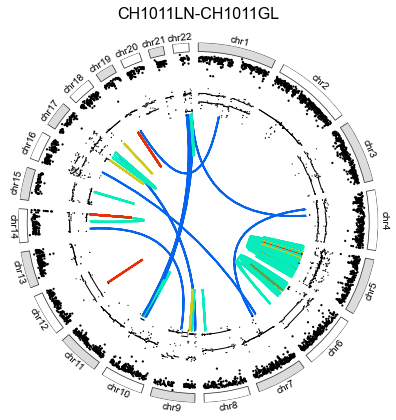

In [23]:

sv_pt = sv_pt[sv_pt.chr2 != 23]

pt_name = 'CH1011LN-CH1011GL'

maf['vaf'] = maf.apply(lambda x: x['t_alt_count'] / (x['t_alt_count'] + x['t_ref_count']), axis=1)


seg_df = seg_df[seg_df.Chromosome != 'X']



filter_vaf_val = 0.15
maf = maf[maf['vaf'] > filter_vaf_val]
circle = Gcircle(figsize= (5,5))
circle.figure.suptitle(f'{pt_name}', fontsize=16, y =1.1)
plot_circle(circle)
plot_linkplot(circle, sv_pt, radius=600)
plot_rainfall(circle, pt_name, maf, raxis_range=(800, 950), marker_colors='highlight')
plot_seg(circle, seg_df, raxis_range=(600, 800))


In [ ]:
# read in excel doc with sheets
# svs = pd.read_excel('./SVevents.xlsx', sheet_name=None)

# read in workspace data
wm = dm.WorkspaceManager("broad-firecloud-ibmwatson/Getz_Wu_Richters_WGS_UK")
pairs = wm.get_pairs()
pairs.dropna(subset=['mutation_validator_validated_maf_WGS', 'ConsensusSV_filtered_results_txt'], inplace=True)

values_all   = [] 
arcdata_dict = collections.defaultdict(dict)

with PdfPages('Circos_plot.pdf') as pdf:
    for pt_name in pairs.index:

        sv_url = pairs.loc[pt_name, 'ConsensusSV_filtered_results_txt']
        sv_pt = pd.read_csv(sv_url, sep='\t', comment='#')

    #     sv_pt = svs[pt_name]
        sv_pt = sv_pt[sv_pt.chr2 != 23]

        maf_fn = pairs.loc[pt_name, 'mutation_validator_validated_maf_WGS']
        maf = pd.read_csv(maf_fn, sep='\t', comment='#')
        maf['vaf'] = maf.apply(lambda x: x['t_alt_count'] / (x['t_alt_count'] + x['t_ref_count']), axis=1)


        filter_vaf_val = 0.15
        maf = maf[maf['vaf'] > filter_vaf_val]
        
        seg_fn = pairs.loc[pt_name, 'alleliccapseg_tsv_WGS']
        seg_df = pd.read_csv(seg_fn, sep='\t', comment='#')
        seg_df = seg_df[seg_df.Chromosome != 'X']

        circle = Gcircle(figsize= (7,7))
        circle.figure.suptitle(f'{pt_name}', fontsize=16, y =1.1)
        plot_circle(circle)
        # plot_cytobands(circle)
        plot_seg(circle, seg_df, raxis_range=(600, 800))
        plot_linkplot(circle, sv_pt, radius=600)
        plot_rainfall(circle, pt_name, maf, raxis_range=(800, 950), marker_colors='highlight')
        
        
        # circle.figure.savefig('./test_circos_plot.pdf')
#         circle.figure.savefig(f'./WGS_circos_plots/{pt_name}_circos_plot.pdf')
        pdf.savefig(circle.figure, bbox_inches='tight')

/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,13,38,73,88,95,128,158,185,187,195,197,199,201,203) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1003CLL-CH1003GL cutoff: 1000, with 1 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,13,38,56,72,73,84,88,91,92,95,96,97,98,99,128,153,154,156,157,158,159,160,161,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,190,191,192,195,196,197,199,201,202,203) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1003LN-CH1003GL cutoff: 1000, with 8 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,13,38,56,70,71,73,84,90,95,128,153,154,156,157,158,159,160,161,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,190,191,192,195,196,197,199,201,202) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1011CLL-CH1011GL cutoff: 1000, with 0 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,38,84,88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1011LN-CH1011GL cutoff: 1000, with 0 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (38,56,73,74,84,95,96,97,98,99,100,102,103) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1017LN-CH1017GL cutoff: 1000, with 4 clusters
CH1018LN-CH1018GL cutoff: 1000, with 1 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,13,84,88,96,97,98,99,128,158,185,187,195,197,199,201,203) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1019CLL-CH1019GL cutoff: 1000, with 5 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,13,56,84,88,96,97,98,99,128,158,185,187,195,197,199,201,203) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1019LN-CH1019GL cutoff: 1000, with 4 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (40,41,56,57,72,74,75,84,91,92,102,103,104,105,128,203) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1021CLL-CH1021GL cutoff: 1000, with 1 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,13,38,56,88,96,97,98,99,128,158,185,187,195,197,199,201) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1030CLL-CH1030GL cutoff: 1000, with 0 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,38,56,74,84,88,102,103,128) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1042LN-CH1042GL cutoff: 1000, with 4 clusters
